In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

from keras.models import load_model

In [2]:
train = pd.read_csv('train_dataset.csv')
train.head()

,date,iso_week,open,high,low,close,volume,market_capitalization,close_point_relative_normalization,volume_point_relative_normalization
0,2016-01-01,2016-00,430.72,436.25,427.51,434.33,36278900.0,6.473530e+09,0.000000,0.000000
1,2016-01-02,2016-00,434.62,436.06,431.87,433.44,30096600.0,6.533630e+09,-0.002049,-0.170410
2,2016-01-03,2016-01,433.58,433.74,424.71,430.01,39633800.0,6.519500e+09,0.000000,0.000000
3,2016-01-04,2016-01,430.06,434.52,429.08,433.09,38477500.0,6.468180e+09,0.007163,-0.029175
4,2016-01-05,2016-01,433.07,434.18,429.68,431.96,34522600.0,6.515380e+09,0.004535,-0.128961


In [3]:
def create_groups(data, group_size=7):
    samples = []
    for i in range(0, len(data), group_size):
        sample = list(data[i:i + group_size])
        if len(sample) == group_size:
            samples.append(np.array(sample).reshape(1, group_size))
    
    return np.array(samples)

In [4]:
len(train) % 7

2

In [5]:
data = create_groups(train['close_point_relative_normalization'][2:].values)
print(data.shape)

(77, 1, 7)


In [6]:
X_train = data[:-1, :].reshape(1, 76, 7)
Y_validation = data[-1].reshape(1, 7)
print(X_train.shape)
print(Y_validation.shape)

(1, 76, 7)
(1, 7)


In [7]:
model = load_model('bitcoin_lstm_v0.h5')

In [8]:
%%time
#  Train the model
history = model.fit(
    x=X_train, y=Y_validation,
    batch_size=32, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 3/100
1/1 [==============================] - 0s 997us/step - loss: 0.0016
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 9.4879e-04
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 8.0897e-04
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 6.8591e-04
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 5.7667e-04
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 4.7957e-04
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 3.9360e-04
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 3.1814e-04
Epoch 13/100
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 9.2524e-06
Epoch 100/100
1/1 [==============================] - 0s 2ms/step - loss: 6.2713e-06
Wall time: 5.34 s


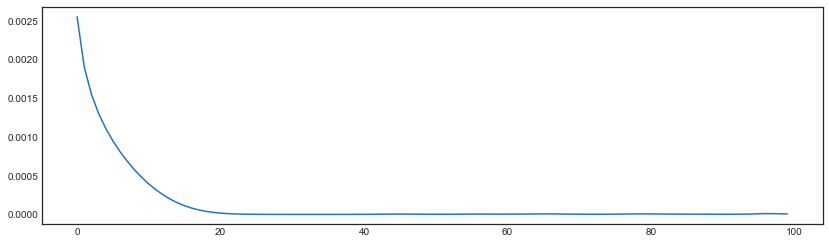

In [9]:
pd.Series(history.history['loss']).plot(figsize=(14, 4));

In [10]:
#  Make predictions using X_train data
predictions = model.predict(x=X_train)[0]
predictions

array([-0.00108575,  0.01797428,  0.07015423,  0.05762846,  0.05892186,
        0.07416938,  0.02269172], dtype=float32)

In [11]:
def denormalize(series, last_value):
    """Denormalize the values for a given series.
    
    This uses the last value available (i.e. the last
    closing price of the week before our prediction)
    as a reference for scaling the predicted results.
    """
    result = last_value * (series + 1)
    return result

In [12]:
last_weeks_value = train[train['date'] == train['date'][:-7].max()]['close'].values[0]

denormalized_prediction = denormalize(predictions, last_weeks_value)
denormalized_prediction

array([2652.9963, 2703.6174, 2842.201 , 2808.9343, 2812.3691, 2852.865 ,
       2716.1465], dtype=float32)

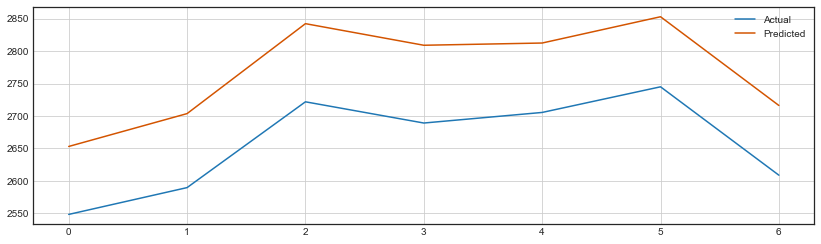

In [13]:
plt.figure(figsize=(14, 4))

plt.plot(train['close'][-7:].values, label='Actual')
plt.plot(denormalized_prediction, color='#d35400', label='Predicted')

plt.grid()
plt.legend();

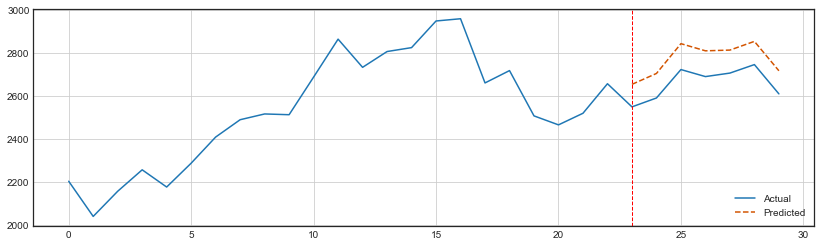

In [14]:
prediction_plot = np.zeros(len(train)-2)
prediction_plot[:] = np.nan
prediction_plot[-7:] = denormalized_prediction

plt.figure(figsize=(14, 4))
plt.plot(train['close'][-30:].values, label='Actual')
plt.plot(prediction_plot[-30:], color='#d35400', linestyle='--', label='Predicted')
plt.axvline(30 - 7, color='r', linestyle='--', linewidth=1)

plt.grid()
plt.legend(loc='lower right');